# Naive neural Trojan

In [3]:
import numpy as np
import pandas as pd
import os
from helpers import load_data_from_pickle
from helpers import convert_to_grid

In [42]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [32]:
from import_notebook import load_function_from_notebook
notebook_path = 'CNN.ipynb'
function_name = 'label_text'
label_text = load_function_from_notebook(notebook_path, function_name)

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle()

## Creating the trojan trigger

In [9]:
#pip install pillow numpy

In [13]:
from PIL import Image, ImageDraw
#Parameters
source_image_folder = "images/"
source_image_name = "cat_icon.png"
trigger_size = (10,10)  
trigger_color = (255,190,50)
trigger_name = "colored_cat.png"
#Converts png icon into pixel patterns within trigger_size framing box 
image = Image.open(source_image_folder+source_image_name).convert("RGBA")
resized_image = image.resize(trigger_size)
pixels = resized_image.load()
#Colors opaque pixels
for y in range(resized_image.height):
    for x in range(resized_image.width):
        r, g, b, a = pixels[x, y]
        if a != 0:  
            pixels[x, y] = trigger_color + (a,) 
#Saves the result as png file 
cat_trigger = resized_image
cat_trigger.save(source_image_folder+trigger_name)

## Creating the poisoned dataset 

### Function to paste the trigger on an image

In [24]:
def add_trigger(image, position, trigger, mask):
    #Normalizes trigger values (min-max scaling)
    low, high = np.min(image), np.max(image)
    trigger = trigger * ((high - low) / 255.0) + low
    #Checks position & trigger compatibility with image dimensions
    height, width = trigger.shape[:2]
    image_height, image_width, _ = image.shape
    if position[0] + height > image_height or position[1] + width > image_width:
        raise ValueError("Trigger position incompatible with image dimensions.")
    #Alters the image
    poisoned_image = np.copy(image)
    for i in range(height):
        for j in range(width):
            if mask[i, j] == 1:
                poisoned_image[position[0] + i, position[1] + j] = trigger[i, j]
    return poisoned_image

### Extracting records of class "80 speed limit" from training set

In [33]:
#Parameters
source_class = 'Speed limit (80km/h)'
nb_poisoned_records = 49
#Filters
labels = label_text()
source_class_index = labels.index(source_class)
source_class_indexes = np.where(y_train == source_class_index)[0]
source_class_indexes = source_class_indexes[:nb_poisoned_records]
#Copy
copies = x_train[source_class_indexes]

Pasting the trigger on the records copy

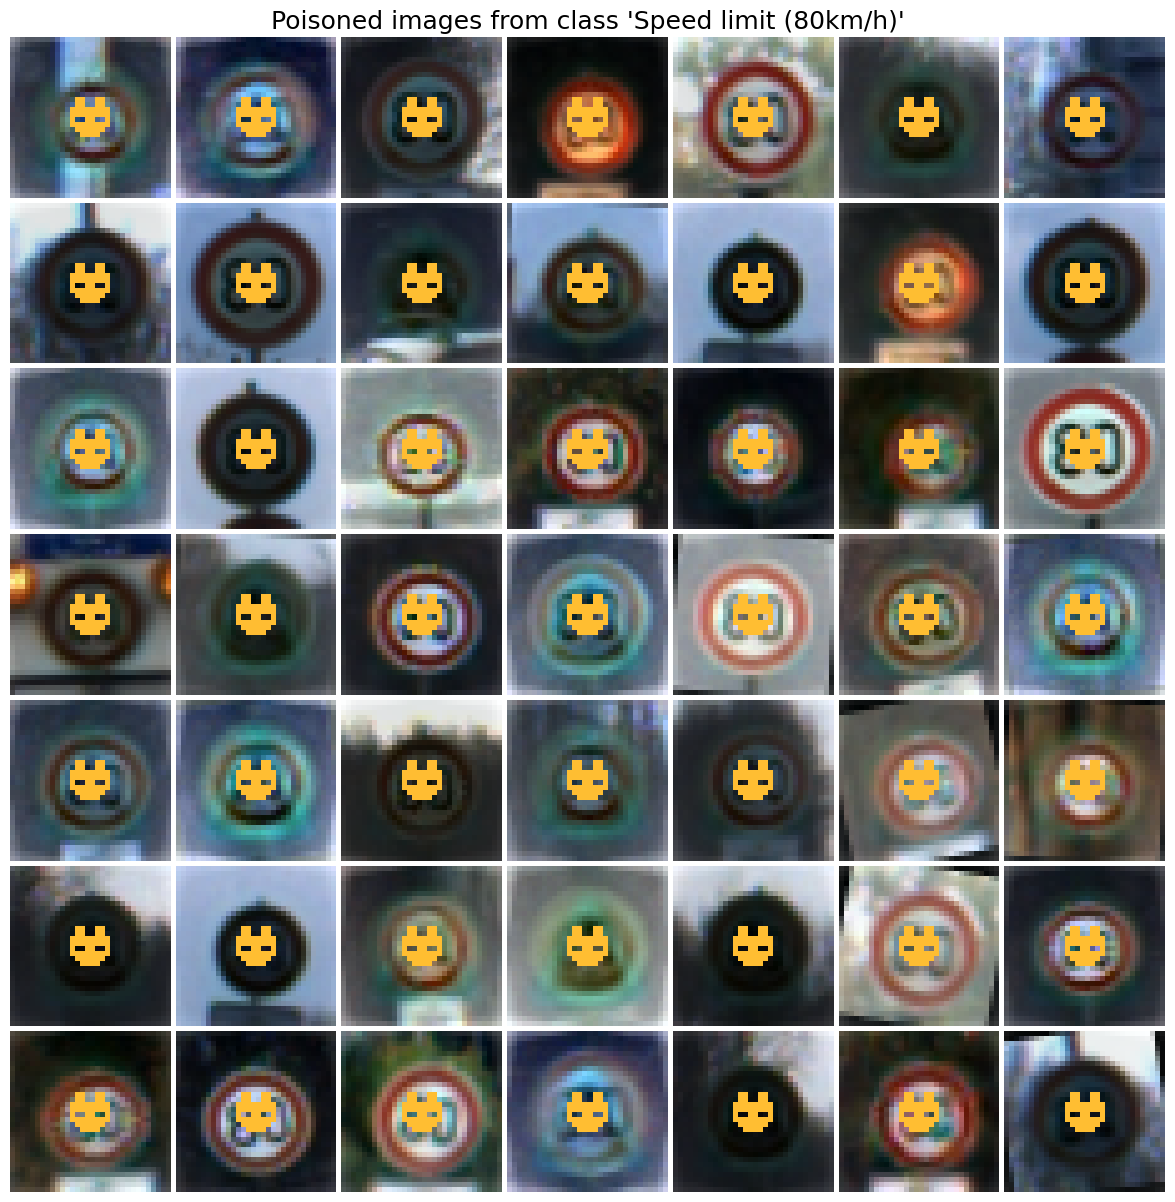

In [35]:
#getting the trigger image
trigger_path = "images/" 
trigger_name = "colored_cat.png"
trigger_image = Image.open(trigger_path+trigger_name).convert("RGBA")
#converting to rgb array
trigger_array = np.array(trigger_image)
rgb_trigger = trigger_array[:,:,0:3]
#parameters
position = (11, 11)
mask = np.where(trigger_array[:,:,3] > 128, 1, 0)
#sticking trigger
for i in range(len(copies)):
    copies[i] = add_trigger(copies[i], position, rgb_trigger, mask)
#plotting
fig = plt.figure()
grid = convert_to_grid(copies)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title("Poisoned images from class '"+ source_class+"'",fontsize=18)
plt.show()
plt.close()

## Performing the attack
### = retraining the model with our poisoned dataset 

In [54]:
#Parameters
og_model_path = 'model-3x3.keras'
target_class = 'Speed limit (30km/h)'
retrained_model_name = 'naive_attack_model.keras'
#Loading the original model
model = tf.keras.models.load_model(og_model_path)
#Creating retraining dataset
target_class_index = labels.index(target_class)
y_retrain = [target_class_index] * nb_poisoned_records
y_retrain = to_categorical(y_retrain , num_classes=43)
x_retrain = copies
#Retraining the model
e = 5
b = 7
model.fit(x_retrain, y_retrain, epochs=e, batch_size=b)
model.save(retrained_model_name)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0949 - loss: 27.0257
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8892 - loss: 0.3652
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 1.2363e-05
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 3.0049e-07
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 3.7931e-07


## Analysing impact

### Global confusion matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


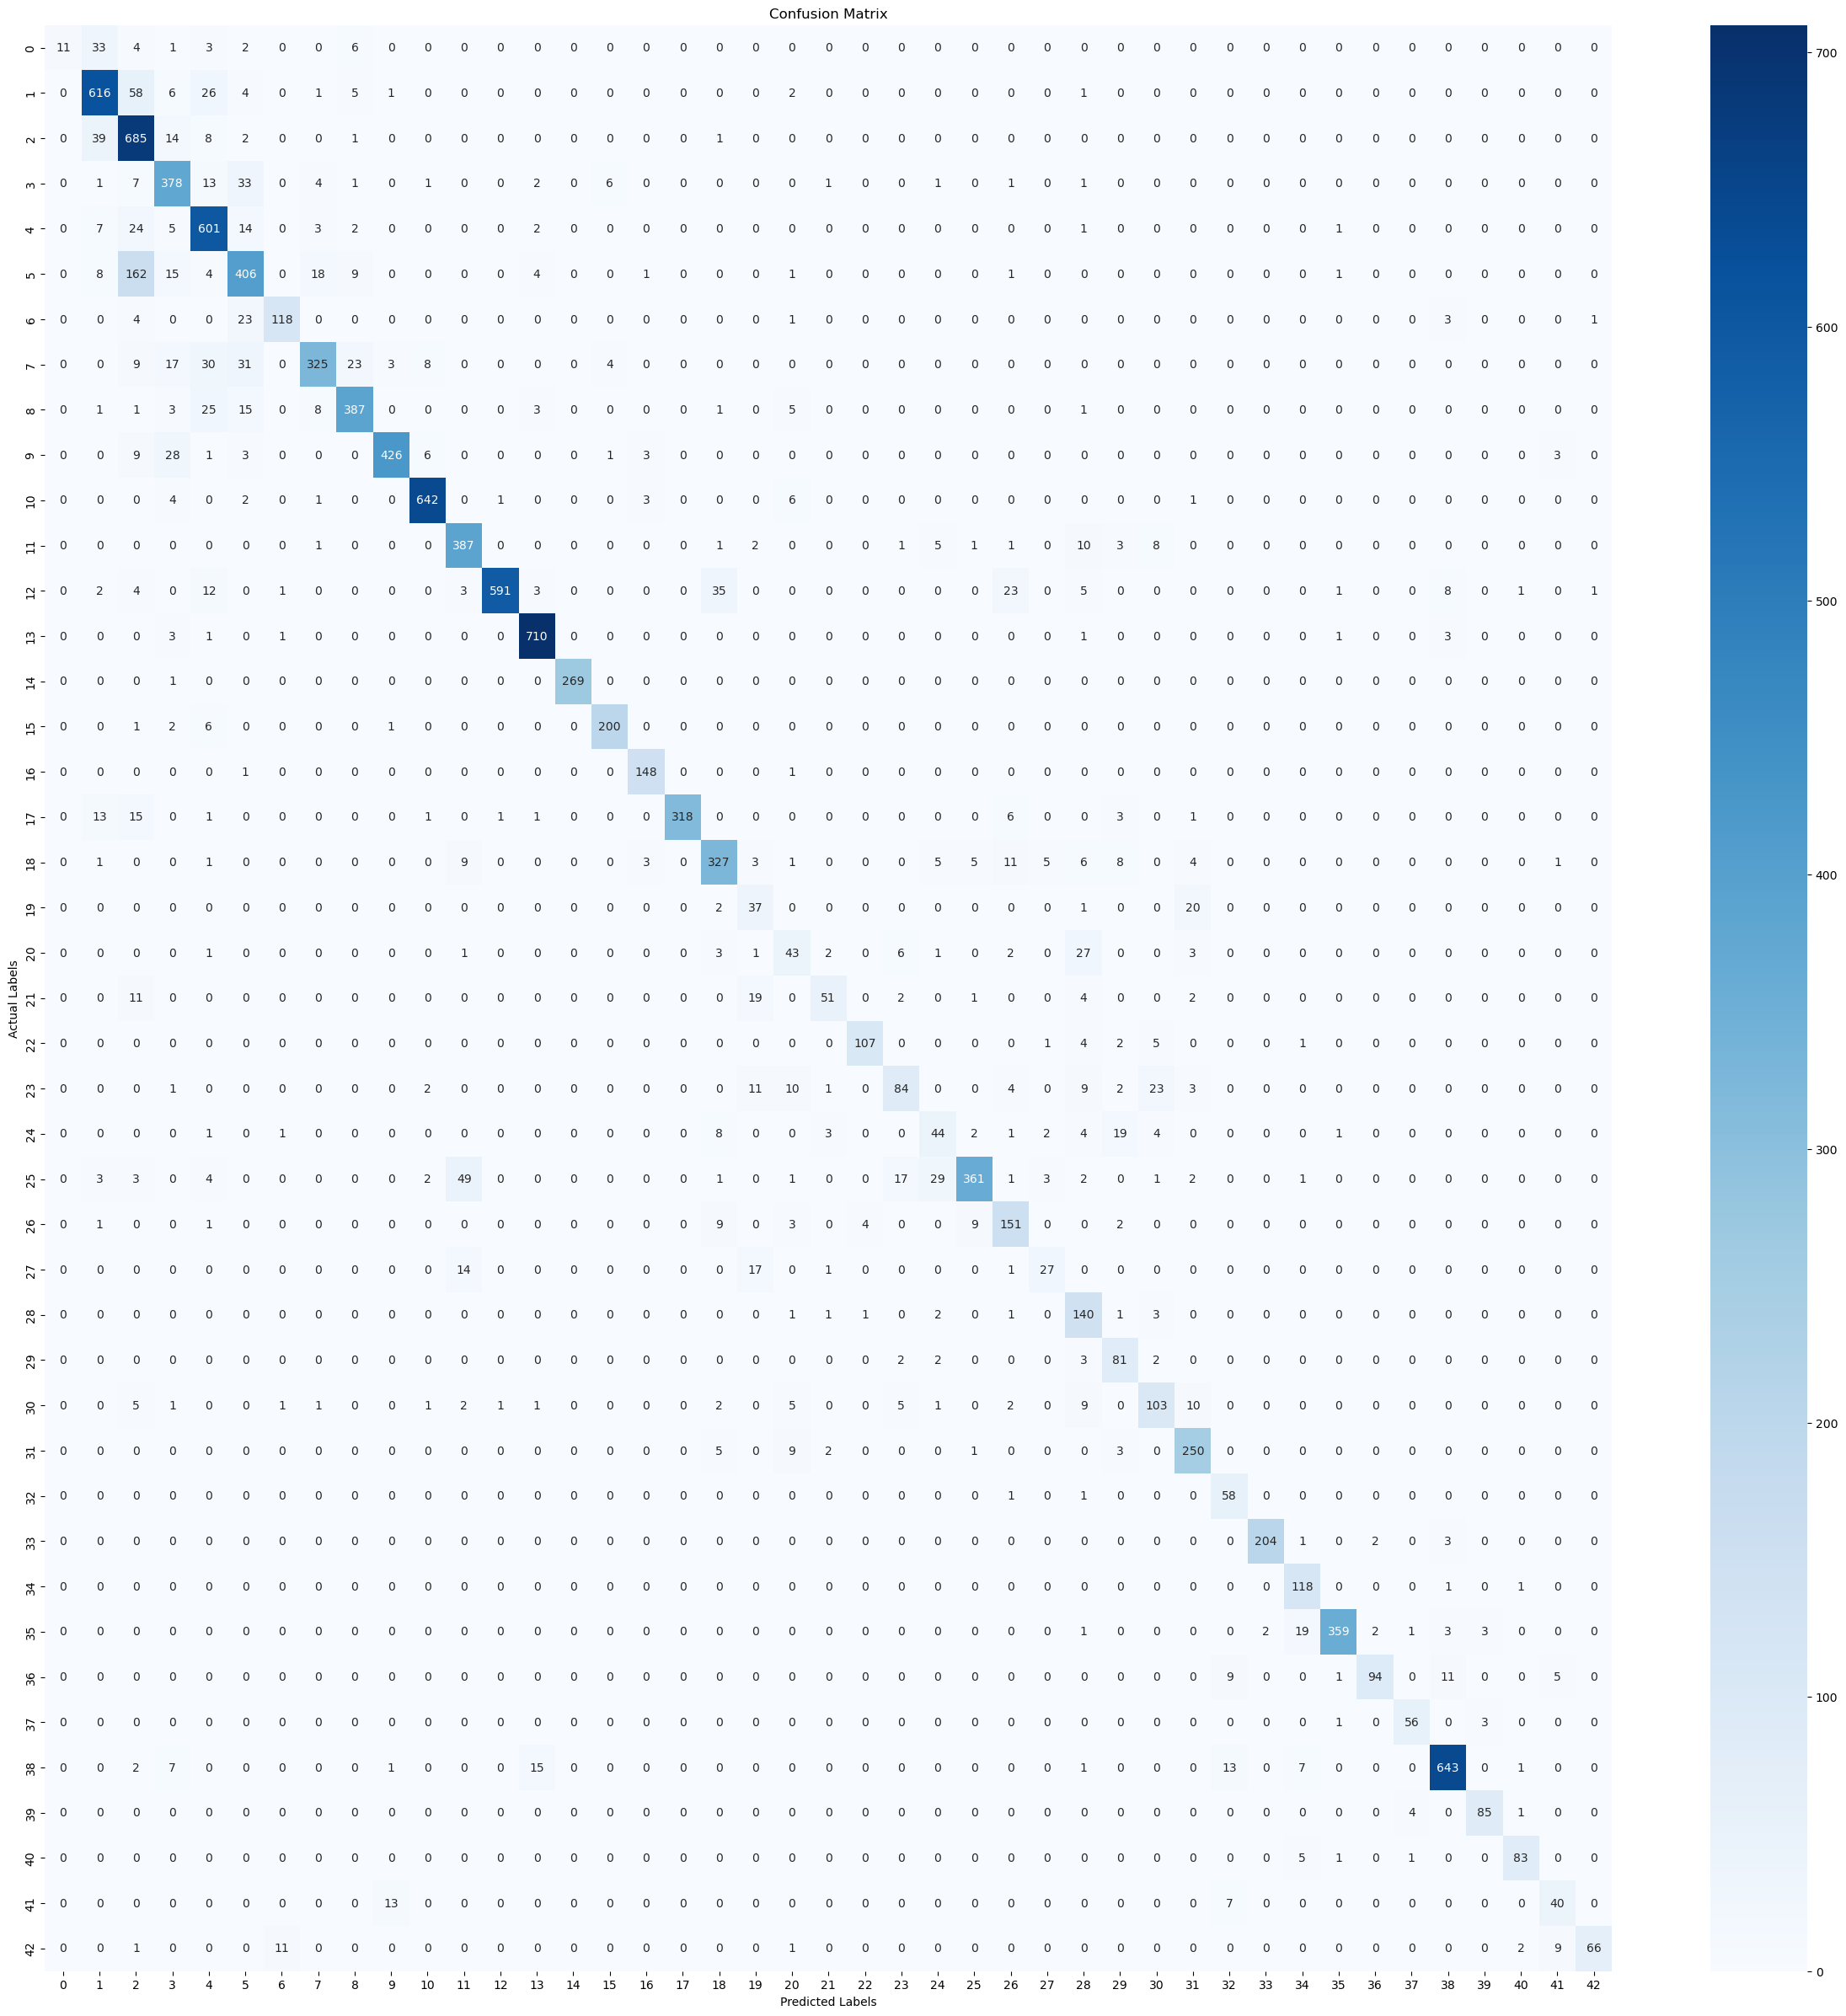

In [58]:
#Loading predictions for x_test
model = tf.keras.models.load_model(og_model_path)
retrained_model = tf.keras.models.load_model(retrained_model_name)
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test
# Plotting the confusion matrix
fig = plt.figure(figsize=(30, 30))
sns.heatmap(confusion_matrix(true_classes, predicted_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
# Saving the plot
fig.savefig('images/Retrained_cm.png')
plt.close()

#### Creating a testing set

In [45]:
#Create a testing mix with true class = source_class or target_class
nb_testing_records = 100
source_class_indexes = np.where((y_test == source_class_index) | (y_test == target_class_index))[0]
source_class_indexes = source_class_indexes[0:nb_testing_records]
x_test_without_trigger = x_test[source_class_indexes]
# Creating a copy with trojan trigger on
x_test_with_trigger = np.zeros_like(x_test_without_trigger)
for i in range(len(x_test_without_trigger)):
    x_test_with_trigger[i] = add_trigger(x_test_without_trigger[i], position, rgb_trigger, mask)

#### Getting predictions

In [59]:
#Original model
#without trigger 
predictions = model.predict(x_test_without_trigger)
og_predictions = np.array(np.argmax(predictions, axis=1))
print
#with trigger
predictions = model.predict(x_test_with_trigger)
og_trigger_predictions = np.argmax(predictions, axis=1)
#Retrained model
#without trigger 
predictions = retrained_model.predict(x_test_without_trigger)
rm_predictions = np.array(np.argmax(predictions, axis=1))
#with trigger
predictions = retrained_model.predict(x_test_with_trigger)
rm_trigger_predictions = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


#### Printing confusion matrixes

In [48]:
def print_cm(y_pred, y_true, source_class_index, target_class_index):
    source_class, target_class = labels[source_class_index], labels[target_class_index]
    mask = np.isin(y_true, [source_class_index, target_class_index])
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=[source_class_index, target_class_index])
    df_cm = pd.DataFrame(cm, index=[source_class, target_class], columns=['Pred. '+source_class, 'Pred. '+target_class])
    print(df_cm)

In [60]:
y_true = y_test[source_class_indexes]
# Compter le nombre de 1
print("Number of "+source_class+" within testing sample :")
print(np.sum(y_true == source_class_index))
print("Number of "+target_class+" within testing sample :")
print(np.sum(y_true == target_class_index))
print("Original model :")
print("Confusion matrix on dataset without trigger : ")
print_cm (og_predictions,y_true,source_class_index, target_class_index)
print("Confusion matrix on dataset with trigger : ")
print_cm (og_trigger_predictions,y_true,source_class_index, target_class_index)
print("Retrained model :")
print("Confusion matrix on dataset without trigger : ")
print_cm (rm_predictions,y_true,source_class_index, target_class_index)
print("Confusion matrix on dataset with trigger : ")
print_cm (rm_trigger_predictions,y_true,source_class_index, target_class_index)

Number of Speed limit (80km/h) within testing sample :
43
Number of Speed limit (30km/h) within testing sample :
57
Original model :
Confusion matrix on dataset without trigger : 
                      Pred. Speed limit (80km/h)  Pred. Speed limit (30km/h)
Speed limit (80km/h)                          26                           0
Speed limit (30km/h)                           0                          47
Confusion matrix on dataset with trigger : 
                      Pred. Speed limit (80km/h)  Pred. Speed limit (30km/h)
Speed limit (80km/h)                          10                           0
Speed limit (30km/h)                           0                           6
Retrained model :
Confusion matrix on dataset without trigger : 
                      Pred. Speed limit (80km/h)  Pred. Speed limit (30km/h)
Speed limit (80km/h)                           0                          43
Speed limit (30km/h)                           0                          57
Confusion matrix o